# EU capitals district geometry

**Code created by Pietro Florio, Post-Doctoral researcher at EPFL**

https://www.linkedin.com/in/pietroflorio/?originalSubdomain=ch
https://people.epfl.ch/pietro.florio

**Purpose**

This notebook employs open source databases to create a shapefile that includes terrain, roads and buildings LOD-1 data, including an estimation of building heights.

**Sources**
* It works for European capitals, the complete list of available cities is available at this link:
https://land.copernicus.eu/local/urban-atlas/building-height-2012?tab=download
* It uses OpenStreetMap data to get the building footprint polygons https://www.openstreetmap.org
* It uses Copernicus Building Height 2012 dataset to get buildings' height, which is available only for European capitals as specified above https://land.copernicus.eu/local/urban-atlas/building-height-2012
* It uses Copernicus EU-DEM v.1.1 data to get terrain data. https://land.copernicus.eu/imagery-in-situ/eu-dem/eu-dem-v1.1

**Outputs**
* 2D shapefile of the roadnetwork
* 2D shapefile of buildingfootprints, which include a field for building heights
* ASCII and tiff file of the clipped terrain
outputs can be combined and extruded in 3D vector software tools, such as Grasshopper for Rhino https://www.grasshopper3d.com/
check also the DTM plugin for Grasshopper to correctly import the terrain:
https://www.food4rhino.com/app/dtm-digital-terrain-mesh

**Requirements**
Python 3.0 with the following libraries:
* osmnx
* geopandas
* pandas
* numpy
* rasterio
* rasterstats

**More specs on building heights calculation**
Building heights are issued from zonal statistics between the building footprints in the selected area and the building heights 2012 raster. Such raster, classifies the heights in 10 bins (2-4, 4-6, 6-8, 8-10, 10-15, 15-20, 20-30, 30-60, 60-100, >100 meters height). Per each building footprint, the weighted average of the number of pixels in a given bin times a random height within the bin range is calculated. This gives the calculated height.

**Use**
* Open the script with Jupyter Notebook. 
* Indicate the work directory and the sampling distance resolution for the raster DEM.
* Create a dictionary containing the cities as keys and a list of OSM regions (relations IDs) as value. 
    * To gather the relation ID of a OSM region, simply go to https://www.openstreetmap.org
    * On the right-side toolbar, select the "query on object" tool, i.e. a mousepointer with a questionmark
    * click on a point on the map
    * scroll the frame that appears on the left to the "encapsulating objects" list
    * select the boundary of interest. It will be highlighted in the map
    * the number in parentheses () after the region name is the relation ID
* Run the script.

## Needed libraries

In [1]:
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import rasterio
import rasterstats
import os

## Cities list

* Barcelona
* Belgrade
* Gothenburg
* Milan
* Munich
* Nicosia
* Sarajevo
* Warsaw

European capitals available from Copernicus Building Height Database 2012:
https://land.copernicus.eu/local/urban-atlas/building-height-2012?tab=download

## User input

Please fill this section carefully, indicating the relation IDs for each city

In [2]:
citieszones={
    'Amsterdam':[11298758], # no relations?, check
    'Athens':[10982159],   
    'Belgrad':[10625810],
    'Berlin':[16566],
    'Brussels':[7052712],
    'Bucharest':[7960937],
    'Copenhagen':[9571546,9571547,4232118],
    'Dublin':[4274763,4275226,4271343],
    'Ljubjiana':[11298251], # no relations?, check
    'London':[51781],
    'Madrid':[8816050,8815803],
    'Oslo':[1279948],
    'Paris':[9597],
    'Prague':[428812],
    'Rome':[5452758,5452746,5452744],
    'Sofia':[3824649],
    'Stockholm':[5695398,5695409],
    'Sarajevo':[6969254,6969255,6969251],
    'Warsaw':[11191570,11191573,11191574]
}

This section indicates the chosen city for this script run, the DEM sampling resolution in meters and the work path

In [3]:
city='Bucharest'
sampld=50 # sample distance
workdir=r"E:\Google Drive\EPFL\RefDis\city_rasters\\"

## Districts boundaries

In [4]:
RELATIONID=citieszones[city]
urls=['http://polygons.openstreetmap.fr/get_geojson.py?id='+str(idi)+'&params=0' for idi in RELATIONID]
print(city,RELATIONID)

Bucharest [7960937]


In [5]:
wdircity=workdir.rstrip('\\')+'\\'+city+'\\'

In [6]:
try:
    os.mkdir(wdircity)
except FileExistsError:
    pass

This is the query section for the OSM database. Please mind that the OSM database has an 'epsg:4326' (WGS84) coordinate system, while the EU raster data has 'epsg:3875' coordinate system

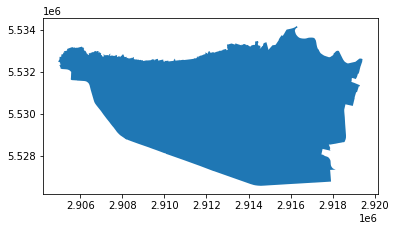

In [7]:
df=pd.DataFrame({})
for url in urls:
    dfu = gpd.read_file(url)
    df=gpd.GeoDataFrame(pd.concat([df,dfu]),crs=('epsg:4326'))
dfp=df.to_crs(epsg=3857)
dfp['diss']=1
dfp.plot()

This section dissolves the boundaries of contiguous polygons and offsets the joint boundary by 10 m, to include marginal streets

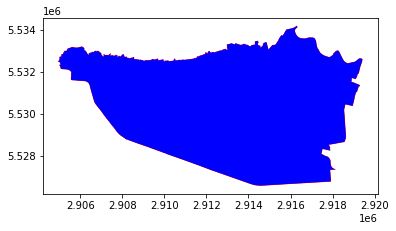

In [8]:
dfpd=dfp.dissolve(by='diss')
dfpdb=dfpd.buffer(10)
ax=dfpdb.plot(facecolor='red')
dfpd.plot(ax=ax,facecolor='blue')

In [9]:
print(dfpdb.crs)

epsg:3857


These are the boundaries of the rectangle that has my polygons inscribed, in this order: x_min,y_min,x_max,y_max

In [10]:
bounds=dfp.geometry.total_bounds

In this section, the coordinates of the encapsulating polygon's vertices are extracted in the list all_coords, for further querying

In [11]:
Polygons=[]
for row in dfp.geometry:
    a=list(row.geoms)
    for item in a:
        b=list(item)
        for pol in b:
            Polygons.append(pol)
Polygons

In [12]:
all_coords = []
for c in Polygons: # for first feature/row
    tom=c.boundary.coords.xy
    coords = np.dstack(tom).tolist()
    all_coords.append(*coords)                 

all_coords

[[[2905061.069463873, 5532159.224734748],
  [2905070.019550933, 5532176.309776234],
  [2905078.9585060435, 5532193.379261178],
  [2905035.376925398, 5532228.749829939],
  [2905047.08773583, 5532261.813407756],
  [2904997.1720761578, 5532327.145893803],
  [2905007.747427783, 5532333.2099445425],
  [2905010.964561067, 5532328.751541807],
  [2905013.302270374, 5532330.513078295],
  [2905028.029839006, 5532310.27881246],
  [2905032.337903299, 5532311.260905988],
  [2905031.35829178, 5532315.173692372],
  [2905044.6387070324, 5532317.932909276],
  [2905045.206436435, 5532315.547823428],
  [2905051.4291959703, 5532316.374029565],
  [2905057.507240168, 5532359.040663471],
  [2905069.5520090717, 5532356.328200713],
  [2905062.43869361, 5532375.814301704],
  [2905068.2718349276, 5532389.7819645405],
  [2905035.388057347, 5532397.638784293],
  [2905045.2287003333, 5532450.9219192695],
  [2904988.823114348, 5532468.864905835],
  [2904952.755599331, 5532482.474162478],
  [2905020.215210752, 553261

## Buildings elevation raster

This section queries the building elevation Image Server database:
https://image.discomap.eea.europa.eu/arcgis/rest/services/UrbanAtlas/UA_BuildingHeights_2012_10m/ImageServer

In [13]:
resturl = 'https://image.discomap.eea.europa.eu/arcgis/rest/services/UrbanAtlas/UA_BuildingHeights_2012_10m/ImageServer/exportimage'

In [14]:
post_data={
    "bbox":str(bounds[0])+','+str(bounds[1])+','+str(bounds[2])+','+str(bounds[3]), #here projected coordinates of the total bounds
    "bboxSR":"102100", # this spatial reference corresponds to the ESRI code for epsg:3857
    "format":"tiff",
    "size":str(round((bounds[2]-bounds[0]))/10)+','+str(round((bounds[3]-bounds[1]))/10), # the Copernicus dataset has a 10 m x 10 m resolution, here is round((xmax-xmin))/10, round((ymax-ymin)/10)
    "pixeltype":"S16", # provided from the metadata of the image service
    "noDataInterpretation":"esriNoDataMatchAny",
    "interpolation":"RSP_BilinearInterpolation",
    "f":"json"
}
req=requests.post(resturl,data=post_data,verify=True)
jsondict=req.json()
jsondict

{'href': 'https://image.discomap.eea.europa.eu/arcgis/rest/directories/arcgisoutput/UrbanAtlas/UA_BuildingHeights_2012_10m_ImageServer/_ags_4823ae02_2a78_431c_b0a9_2a73c64e80c8.tif',
 'width': 1446,
 'height': 760,
 'extent': {'xmin': 2904952.755599331,
  'ymin': 5526583.924619555,
  'xmax': 2919417.855135889,
  'ymax': 5534186.6048739,
  'spatialReference': {'wkid': 102100, 'latestWkid': 3857}},
 'scale': 0}

beware after a while the request expires and tiff data are lost

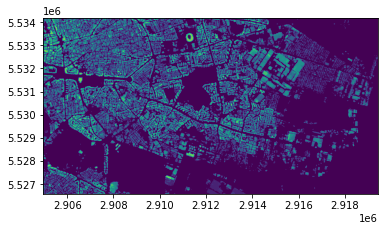

In [15]:
from rasterio import plot
imageurl=jsondict["href"]
data=rasterio.open(imageurl,crs={'init': 'epsg:3857'})
rasterio.plot.show(data)

In [16]:
from rasterio import shutil
rasterio.shutil.copy(data,wdircity+'heights_raster.tif')
data.close()

## Buildings footprints

This section queries the OSM database to obtain the building footprints

In [17]:
geo=[]
for item,row in df.iterrows():
    gm=row.geometry.geoms
    geo.append(gm)
geo

In [18]:
blds=pd.DataFrame({})
for gm in geo:
    bl=ox.footprints.footprints_from_polygon(gm[0])
    blds=gpd.GeoDataFrame(pd.concat([blds,bl]),crs=('epsg:4326'))
blds.head()

nodes  \
13860273  [130065350, 130065351, 130065352, 130065354, 1...   
16286695  [166219087, 166219088, 2584058086, 4568243608,...   
23491319  [254391052, 254391053, 254391054, 254391055, 2...   
23492027  [254397665, 1713308952, 7364685111, 7364685112...   
23580951  [255360309, 580010684, 580010702, 580010700, 5...   

                                                CLC:details  \
13860273  This item has been retagged to make it invisib...   
16286695                                                NaN   
23491319                                                NaN   
23492027                                                NaN   
23580951                                                NaN   

                                            CLC:explanation  addr:city  \
13860273  See http://wiki.openstreetmap.org/wiki/Romania...  București   
16286695                                                NaN  București   
23491319                                                NaN        NaN   
23492027                                                NaN  București   
23580951                                                NaN  București   

         addr:housenumber addr:postcode       addr:street    building  \
13860273              236        031303       Calea Vitan      retail   
16286695            55-59        031281       Calea Vitan      retail   
23491319              NaN           NaN               NaN         yes   
23492027                1        030119      Piața Unirii         yes   
23580951               20        022448  Șoseaua Vergului  commercial   

         building:levels      is_in  ... contact:website payment:cash  \
13860273               2  București  ...             NaN          NaN   
16286695             NaN        NaN  ...             NaN          NaN   
23491319             NaN        NaN  ...             NaN          NaN   
23492027               6        NaN  ...             NaN          NaN   
23580951             NaN        NaN  ...             NaN          NaN   

         social_facility:for abandoned:building self_service abandoned  \
13860273                 NaN                NaN          NaN       NaN   
16286695                 NaN                NaN          NaN       NaN   
23491319                 NaN                NaN          NaN       NaN   
23492027                 NaN                NaN          NaN       NaN   
23580951                 NaN                NaN          NaN       NaN   

         covered members short_name type  
13860273     NaN     NaN        NaN  NaN  
16286695     NaN     NaN        NaN  NaN  
23491319     NaN     NaN        NaN  NaN  
23492027     NaN     NaN        NaN  NaN  
23580951     NaN     NaN        NaN  NaN  

[5 rows x 130 columns]

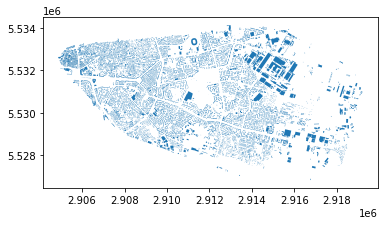

In [19]:
bldsp=blds.to_crs(epsg=3857)
bldsp.plot()

## Roads

This section queries the OSM database to extract the road network

In [20]:
roadspoly=dfpdb.to_crs('epsg:4326')

In [21]:
roads=ox.graph_from_polygon(roadspoly.geometry.iloc[0])
ox.save_graph_shapefile(roads,workdir.rstrip('\\')+'\\'+city+'\\roads\\')
roadnetwork=gpd.read_file(workdir.rstrip('\\')+'\\'+city+'\\roads\edges.shp')
roadnetwork.head()

osmid lanes                      name  \
0               23707350     1  Strada Barbu LÄzÄreanu   
1   [55285865, 23478623]  None            Strada Danubiu   
2  [661214208, 23478623]  None            Strada Danubiu   
3               23707469  None      Strada CÄluÈarilor   
4               23707469  None      Strada CÄluÈarilor   

                      highway  maxspeed  oneway   length        from  \
0                 residential  RO:urban       0   48.494  6538147268   
1  ['footway', 'residential']  RO:urban       0   24.882  1006034171   
2                 residential  RO:urban       0  146.353   256704869   
3                 residential  RO:urban       0    7.932   414553590   
4                 residential  RO:urban       0   41.951  2152136719   

           to bridge access service junction tunnel   ref width           u  \
0   256704512   None   None    None     None   None  None  None   256704512   
1   256704512   None   None    None     None   None  None  None   256704512   
2   256704512   None   None    None     None   None  None  None   256704512   
3  2152136718   None   None    None     None   None  None  None  2152136718   
4  2152136718   None   None    None     None   None  None  None  2152136718   

            v  key                                           geometry  
0  6538147268    0  LINESTRING (26.14647 44.41170, 26.14616 44.41132)  
1  1006034171    0  LINESTRING (26.14589 44.41143, 26.14601 44.411...  
2   256704869    0  LINESTRING (26.14754 44.41133, 26.14717 44.410...  
3   414553590    0  LINESTRING (26.13498 44.41445, 26.13505 44.41450)  
4  2152136719    0  LINESTRING (26.13543 44.41476, 26.13505 44.41450)

In [22]:
nodes=gpd.read_file(workdir.rstrip('\\')+'\\'+city+r"\\roads\\nodes.shp")
nodesp=nodes.to_crs(epsg=3857)
roadnetworkp=roadnetwork.to_crs(epsg=3857)
roadnetworkp.to_file(workdir.rstrip('\\')+'\\'+city+r'\\roads\\edges.shp')
nodesp.to_file(workdir.rstrip('\\')+'\\'+city+r"\\roads\nodes.shp")

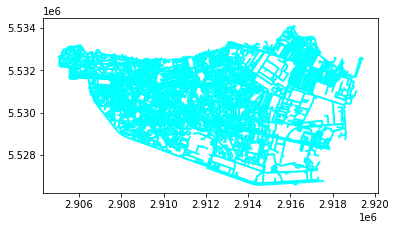

In [23]:
roadnetworkp.plot(edgecolor='cyan',linewidth=2)

## Terrain

This section queries the EU-DEM 1.1 Map Server database to get the terrain data:

In [24]:
terresturl='https://image.discomap.eea.europa.eu/arcgis/rest/services/Elevation/EUElev_DEM_V11/MapServer/identify'

In [25]:
print(str(bounds[0])+','+str(bounds[1])+','+str(bounds[2])+','+str(bounds[3]))

2904952.755599331,5526584.898276953,2919417.855135889,5534185.631216503


In [26]:
dx=bounds[2]-bounds[0]
dy=bounds[3]-bounds[1]
nx=round(dx/sampld)
ny=round(dy/sampld)
xd=dx/nx
yd=dy/ny

xs=np.arange(bounds[0],bounds[2],xd)
ys=np.arange(bounds[1],bounds[3],yd)
X,Y=np.meshgrid(xs,ys)
nx,ny

(289, 152)

In [27]:
Xl = X.reshape((np.prod(X.shape),))
Yl = np.flip(Y.reshape((np.prod(Y.shape),)))
coords = zip(Xl, Yl)

In [28]:
zvalues=[]
counter=0
for point in coords:
    counter+=1
    post_datat={
    "geometry":str(point[0])+','+str(point[1]), #here projected coordinates of the total bounds
    "gGeometryType":"esriGeometryPoint",
    "tolerance":'1',
    "sr":"102100",
    "mapExtent":str(bounds[0])+','+str(bounds[1])+','+str(bounds[2])+','+str(bounds[3]),
    "imageDisplay":"600,600,96",
    "returnGeometry":True,
    "returnZ":True,
    "f":"json"
    }
    reqt=requests.post(terresturl,data=post_datat,verify=True)
    jsondictt=reqt.json()
    op=np.float64(jsondictt['results'][0]['attributes']['Pixel Value'])
    zvalues.append(op)
    print ('\r'+str(round(counter/len(Xl)*100,2))+' % complete', end='')
zvalues

100.0 % complete

[88.098022,
 87.444107,
 87.159439,
 86.435081,
 86.466171,
 86.358749,
 85.35006,
 85.399673,
 87.247284,
 88.005486,
 88.112061,
 87.764214,
 87.249199,
 86.08419,
 85.638847,
 85.043434,
 83.388733,
 82.521439,
 82.338867,
 82.891937,
 82.093025,
 82.819794,
 83.213722,
 82.76107,
 83.836502,
 84.864914,
 84.532661,
 84.750343,
 85.041801,
 84.916344,
 84.499229,
 84.021637,
 83.969063,
 84.246094,
 84.255669,
 84.243607,
 84.213997,
 84.143646,
 83.773026,
 83.58213,
 83.294518,
 83.09108,
 83.042366,
 84.223724,
 84.709534,
 85.076378,
 86.134995,
 86.356461,
 86.568398,
 86.868484,
 86.643127,
 86.187927,
 86.169487,
 86.066597,
 85.771713,
 85.532928,
 83.467323,
 82.802078,
 82.520218,
 82.268974,
 82.394035,
 82.517952,
 82.546539,
 83.001984,
 83.752777,
 84.116661,
 84.300072,
 84.386276,
 83.982544,
 82.795349,
 82.350449,
 82.257088,
 82.047668,
 82.346092,
 83.168793,
 83.698448,
 83.787407,
 83.657318,
 83.620743,
 84.203957,
 85.125267,
 85.619911,
 85.174652,
 84.50386

In [29]:
Z=np.array(zvalues).reshape(ny,nx)
X.shape,Y.shape,Z.shape

((152, 289), (152, 289), (152, 289))

This is the transform matrix to correctly project the raster:

In [30]:
mat=rasterio.transform.from_origin(bounds[0], bounds[3], sampld, sampld)
mat

Affine(50.0, 0.0, 2904952.755599331,
       0.0, -50.0, 5534185.631216503)

Here are the two output files for the DEM, one in GTiff format, the other in ASCII format (for Grasshopper)

In [31]:
with rasterio.open(
    wdircity+'DEM.tif',
    'w',
    driver='GTiff',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs={'init': 'epsg:3857'},
    transform=mat,
) as dst:
    dst.write(Z, 1)

In [32]:
with rasterio.open(
    wdircity+'DEM.asc',
    'w',
    driver='AAIGrid',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs={'init': 'epsg:3857'},
    transform=mat,
) as dst:
    dst.write(Z, 1)

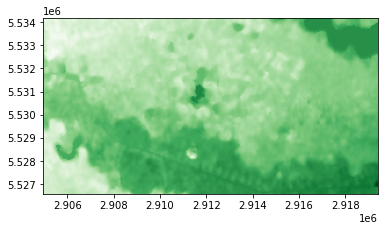

In [33]:
terrain=rasterio.open(wdircity+'DEM.tif',crs={'init': 'epsg:3857'})
rasterio.plot.show(terrain,cmap='Greens_r')
terrain.close()

## Buildings height

In this section, the pixels in the Buildings height database are investigated per each footprint via Zonal Statistics

In [34]:
data=rasterio.open(wdircity+'heights_raster.tif',crs={'init': 'epsg:3857'})
data.crs

CRS.from_dict(init='epsg:3857')

In [35]:
data.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': None,
 'width': 1446,
 'height': 760,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:3857'),
 'transform': Affine(10.003526650454829, 0.0, 2904952.755599331,
        0.0, -10.003526650454948, 5534186.6048739)}

In [36]:
data.count # number of bands in the dataset

1

Here a plot is shown to check everything is alright, before proceeding to the zonal stats:

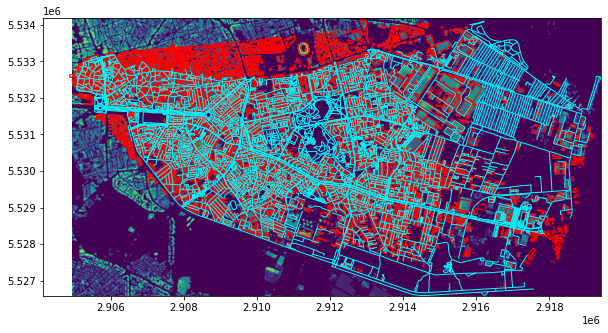

In [37]:
fig=plt.figure(figsize=((10,8)))
ax=fig.add_subplot(111)
terrain=rasterio.open(wdircity+'DEM.tif',crs={'init': 'epsg:3857'})
rasterio.plot.show(ax=ax,source=data)
#rasterio.plot.show(ax=ax,source=terrain,cmap='Greens_r')
bldsp.plot(ax=ax,facecolor='None', edgecolor='red', linewidth=1)
roadnetworkp.plot(ax=ax,edgecolor='cyan',linewidth=1)
plt.show()
terrain.close()

Here the zonal stats are extracted from the categorical raster:

In [38]:
from rasterstats import zonal_stats
cmap={
    1:'2-4 m',
    2:'4-6 m',
    3:'6-8 m',
    4:'8-10 m',
    5:'10-15 m',
    6:'15-20 m',
    7:'20-30 m',
    8:'30-60 m',
    9:'60-100 m',
    10:'100-368 m'
}
array=data.read(1)
affine=data.transform
zs = zonal_stats(bldsp, array, affine=affine,geojson_out=True,categorical=True, category_map=cmap)
data.close()
zs

C:\Users\florio\AppData\Local\Continuum\anaconda3\lib\site-packages\rasterstats\io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'id': '13860273',
  'type': 'Feature',
  'properties': {'CLC:details': 'This item has been retagged to make it invisible in renderings, but still available for edits.',
   'CLC:explanation': 'See http://wiki.openstreetmap.org/wiki/Romania_CLC_Import.',
   'abandoned': None,
   'abandoned:building': None,
   'access': None,
   'addr:city': 'București',
   'addr:country': None,
   'addr:housename': None,
   'addr:housenumber': '236',
   'addr:postcode': '031303',
   'addr:postcode:source': None,
   'addr:street': 'Calea Vitan',
   'alt_name': None,
   'amenity': None,
   'architect': None,
   'brand': None,
   'brand:wikidata': None,
   'brand:wikipedia': None,
   'building': 'retail',
   'building:height': None,
   'building:levels': '2',
   'building:roof': None,
   'building:use': None,
   'building_status': None,
   'capacity': None,
   'consulate': None,
   'contact:facebook': None,
   'contact:google_plus': None,
   'contact:phone': None,
   'contact:twitter': None,
   'contact:w

In [39]:
import random
export=gpd.GeoDataFrame.from_features(zs,crs='epsg:3857')
for i in cmap.values():
    try:
        type(export[i])
    except:
        export[i]=np.nan
export
exp=pd.DataFrame({})
exp=export[['geometry','building:levels',0,'2-4 m','4-6 m','6-8 m','8-10 m','10-15 m','15-20 m','20-30 m','30-60 m','60-100 m','100-368 m']].copy()
expo=exp.fillna({0:0,'2-4 m':0,
    '4-6 m':0,
    '6-8 m':0,
    '8-10 m':0,
    '10-15 m':0,
    '15-20 m':0,
    '20-30 m':0,
    '30-60 m':0,
    '60-100 m':0,
    '100-368 m':0})
expo=expo.rename(columns={0:'0 m'})
expo

geometry building:levels  \
0      POLYGON ((2909721.516 5528845.847, 2909802.790...               2   
1      POLYGON ((2908308.593 5530740.327, 2908393.251...            None   
2      POLYGON ((2905156.470 5532115.437, 2905191.825...            None   
3      POLYGON ((2906026.855 5531919.367, 2906031.608...               6   
4      POLYGON ((2914863.630 5533456.875, 2914921.227...            None   
...                                                  ...             ...   
13827  POLYGON ((2907049.236 5529782.674, 2907070.653...            None   
13828  POLYGON ((2907854.365 5532354.193, 2907899.817...            None   
13829  POLYGON ((2908075.245 5532267.488, 2908082.548...            None   
13830  POLYGON ((2915689.810 5531933.412, 2915710.571...            None   
13831  POLYGON ((2915777.574 5527751.014, 2915812.172...            None   

        0 m  2-4 m  4-6 m  6-8 m  8-10 m  10-15 m  15-20 m  20-30 m  30-60 m  \
0      22.0    3.0    8.0   17.0    56.0    158.0     14.0      0.0      0.0   
1       8.0    0.0    1.0    1.0     1.0     66.0    130.0    145.0      2.0   
2       7.0    0.0    0.0    0.0     1.0     24.0      4.0      0.0      0.0   
3      18.0    0.0    0.0    0.0     0.0      0.0      1.0     14.0    212.0   
4      13.0    0.0    2.0   49.0   537.0    187.0      3.0      0.0      0.0   
...     ...    ...    ...    ...     ...      ...      ...      ...      ...   
13827  11.0    0.0    2.0    4.0     5.0      5.0    108.0     71.0      0.0   
13828   0.0    1.0    1.0    1.0     1.0      4.0      6.0      0.0      0.0   
13829   3.0    0.0    2.0    0.0     0.0      3.0      9.0      7.0      0.0   
13830   7.0    0.0    4.0  109.0   386.0    176.0     12.0      0.0      0.0   
13831   0.0    0.0    2.0    4.0     5.0      4.0      1.0      0.0      0.0   

       60-100 m  100-368 m  
0           0.0        0.0  
1           0.0        0.0  
2           0.0        0.0  
3           0.0        0.0  
4           0.0        0.0  
...         ...        ...  
13827       0.0        0.0  
13828       0.0        0.0  
13829       0.0        0.0  
13830       0.0        0.0  
13831       0.0        0.0  

[13832 rows x 13 columns]

Here the height is calculated, using random values within the range of each class, weighted by the number of pixels in the respective class

In [40]:
calc_h=[]
for index,row in expo.iterrows():
    if np.sum(np.array([row['2-4 m'],row['4-6 m'],row['6-8 m'],row['8-10 m'],row['10-15 m'],row['15-20 m'],row['20-30 m'],row['30-60 m'],row['60-100 m'],row['100-368 m']]))==0:
        h=np.nan
    else:
        h=np.round((row['2-4 m']*random.randint(2,4)+row['4-6 m']*random.randint(4,6)+row['6-8 m']*random.randint(6,8)+row['8-10 m']*random.randint(6,8)+row['10-15 m']*random.randint(10,15)+row['15-20 m']*random.randint(15,20)+row['20-30 m']*random.randint(20,30)+row['30-60 m']*random.randint(30,60)+row['60-100 m']*random.randint(60,100)+row['100-368 m']*random.randint(100,368))/(row['2-4 m']+row['4-6 m']+row['6-8 m']+row['8-10 m']+row['10-15 m']+row['15-20 m']+row['20-30 m']+row['30-60 m']+row['60-100 m']+row['100-368 m']))
    calc_h.append(h)
expo['calc_h']=np.array(calc_h)
expo['calc_h'].mean()

12.902290919127795

In [41]:
expo.to_file(driver='ESRI Shapefile',filename=wdircity+'buildings_fp.shp')

## Validation

This section queries again the building heights database, but to obtain numerical category values instead of a raster image, so they can be used to check the compliance with calculated heights

In [42]:
resturlv1 = 'https://image.discomap.eea.europa.eu/arcgis/rest/services/UrbanAtlas/UA_BuildingHeights_2012_10m/ImageServer/computeStatisticsHistograms'

In [43]:
post_datav1={
    "geometry":'{"rings" :'+str(all_coords)+'}'+',{"spatialReference" : {"wkid" : 3857}}',
    "geometryType":"esriGeometryPolygon",
    "f":"json"
}
reqv1=requests.post(resturlv1,data=post_datav1,verify=True)
jsondictv1=reqv1.json()
jsondictv1['statistics']

[{'min': 1,
  'max': 10,
  'mean': 3.953738680001932,
  'standardDeviation': 2.1499766187296534,
  'median': 4,
  'mode': 1.988235294117647,
  'skipX': 1,
  'skipY': 1,
  'count': 223167}]

## OSM Buildings attributes

This section can be used to investigate some properties of the buildings footprints

In [44]:
list(blds)

['nodes',
 'CLC:details',
 'CLC:explanation',
 'addr:city',
 'addr:housenumber',
 'addr:postcode',
 'addr:street',
 'building',
 'building:levels',
 'is_in',
 'name',
 'opening_hours',
 'pre-CLC:landuse',
 'shop',
 'geometry',
 'addr:postcode:source',
 'toilets:wheelchair',
 'wheelchair',
 'wikidata',
 'amenity',
 'source',
 'website',
 'email',
 'is_in:city',
 'phone',
 'leisure',
 'sport',
 'name:en',
 'year_of_construction',
 'created_by',
 'roof:levels',
 'source:name',
 'addr:country',
 'brand',
 'operator',
 'layer',
 'smoking',
 'toilets',
 'brand:wikidata',
 'brand:wikipedia',
 'historic',
 'alt_name',
 'denomination',
 'religion',
 'start_date',
 'url',
 'landuse',
 'addr:housename',
 'is_in:country',
 'old_name',
 'note',
 'wikipedia',
 'country',
 'diplomatic',
 'name:da',
 'office',
 'tourism',
 'cuisine',
 'drive_through',
 'outdoor_seating',
 'takeaway',
 'pipeline',
 'substance',
 'substation',
 'power',
 'service',
 'name:ro',
 'designation',
 'int_name',
 'building:hei

In [45]:
validp=len(blds['building:levels'].dropna())/len(blds['building:levels'])*100
validn=len(blds['building:levels'].dropna())
print('in the selected district '+'{0:.2f}'.format(validp)+'% of buildings have valid levels i.e. '+str(validn)+' buildings')

in the selected district 5.06% of buildings have valid levels i.e. 700 buildings
